In [33]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from prophet import Prophet

In [34]:
input_path = r'..\data\freight_data.csv'
new_input_path = r'..\data\2023_09_15_freight_data.csv'

raw_data = pd.read_csv(new_input_path, sep=',', parse_dates=['Date'])
raw_data.columns = [col.lower() for col in raw_data.columns]
raw_data.rename(
    mapper={column: column.lower() for column in raw_data.columns},
)
raw_data.head()

,carrier,date,cost
0,UPS,2018-01-01,528000.0
1,UPS,2018-02-01,500000.0
2,UPS,2018-03-01,550000.0
3,UPS,2018-04-01,488000.0
4,UPS,2018-05-01,490000.0


In [35]:
raw_data.shape

(120, 3)

In [36]:
raw_data.drop_duplicates(inplace=True)
raw_data.shape

(120, 3)

In [37]:
raw_data.head()

,carrier,date,cost
0,UPS,2018-01-01,528000.0
1,UPS,2018-02-01,500000.0
2,UPS,2018-03-01,550000.0
3,UPS,2018-04-01,488000.0
4,UPS,2018-05-01,490000.0


In [38]:
raw_data.describe()

,date,cost
count,120,1.200000e+02
mean,2020-06-16 01:36:00,5.193405e+05
min,2018-01-01 00:00:00,2.000000e+05
25%,2019-03-24 06:00:00,3.624500e+05
50%,2020-06-16 00:00:00,4.975000e+05
75%,2021-09-08 12:00:00,6.491320e+05
max,2022-12-01 00:00:00,1.171280e+06
std,NaN,1.948308e+05


In [39]:
profile = ProfileReport(raw_data, minimal=False, title='Raw Data Exploratory Analysis')

In [40]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

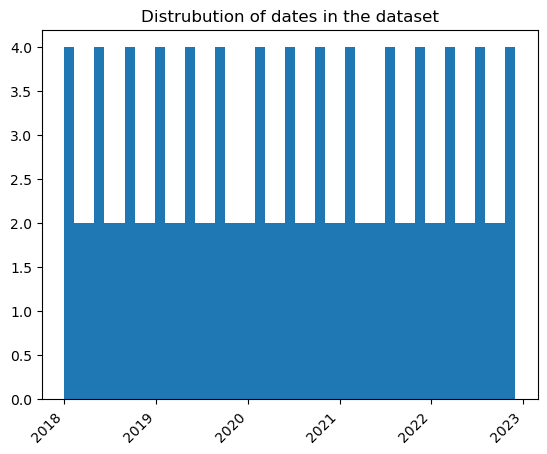

In [41]:
import matplotlib.dates as mdates
# import matplotlib
# # matplotlib.use('TkAgg')

plt.hist(raw_data.date, bins=45)
plt.title('Distrubution of dates in the dataset')
plt.xticks(rotation=45, ha='right')
plt.show()

# Modeling

In [42]:
ups_data = raw_data.loc[raw_data.carrier=='UPS']
fdxg_data = raw_data.loc[raw_data.carrier=='FDXG']
print(f'{ups_data.shape=}')
print(f'{fdxg_data.shape=}')

ups_data.shape=(60, 3)
fdxg_data.shape=(60, 3)


## UPS data

In [43]:
def format_data(data: pd.DataFrame) -> pd.DataFrame:
    return data\
        .rename(
            mapper={
                'date': 'ds',
                'cost': 'y'
            },
            axis=1,
        )\
        .drop('carrier', axis=1)

def train_test_split(data: pd.DataFrame, test_length=int):
    '''preprocesses data and returns train and test dataframes'''

    clean_data = format_data(data)
    train = clean_data[:-test_length]
    test = clean_data[-test_length:]

    return train, test


ups_train, ups_test = train_test_split(ups_data, 12)
fdxg_train, fdxg_test = train_test_split(fdxg_data, 12)
ups_train.head()

,ds,y
0,2018-01-01,528000.0
1,2018-02-01,500000.0
2,2018-03-01,550000.0
3,2018-04-01,488000.0
4,2018-05-01,490000.0


In [44]:
def train_prophet(train: pd.DataFrame, test: pd.DataFrame):
    '''
    Function sets up model, trains it and predicts
    
    Returns a model and the predictions dataframe
    '''
    
    model = Prophet()
    model.fit(train)
    future_data = model.make_future_dataframe(periods=12, freq='MS')
    predictions = model.predict(future_data)
    return model, predictions


ups_model, ups_predictions = train_prophet(ups_train, ups_test)
fdxg_model, fdxg_predictions = train_prophet(fdxg_train, fdxg_test)


09:52:32 - cmdstanpy - INFO - Chain [1] start processing
09:52:33 - cmdstanpy - INFO - Chain [1] done processing
09:52:33 - cmdstanpy - INFO - Chain [1] start processing
09:52:34 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
def plot_predictions(train, test, predictions, model, carrier) -> None:
    '''plots a model for a given set of data'''

    fig = model.plot(predictions, xlabel='date', ylabel='feight_costs')
    plt.plot(test.ds, test.y, color='red', label='actual test values')
    plt.plot(train.ds, train.y, color='green', label='actual train values')
    plt.title(f'{carrier} model predictions with Prophet')
    plt.legend()
    plt.show()

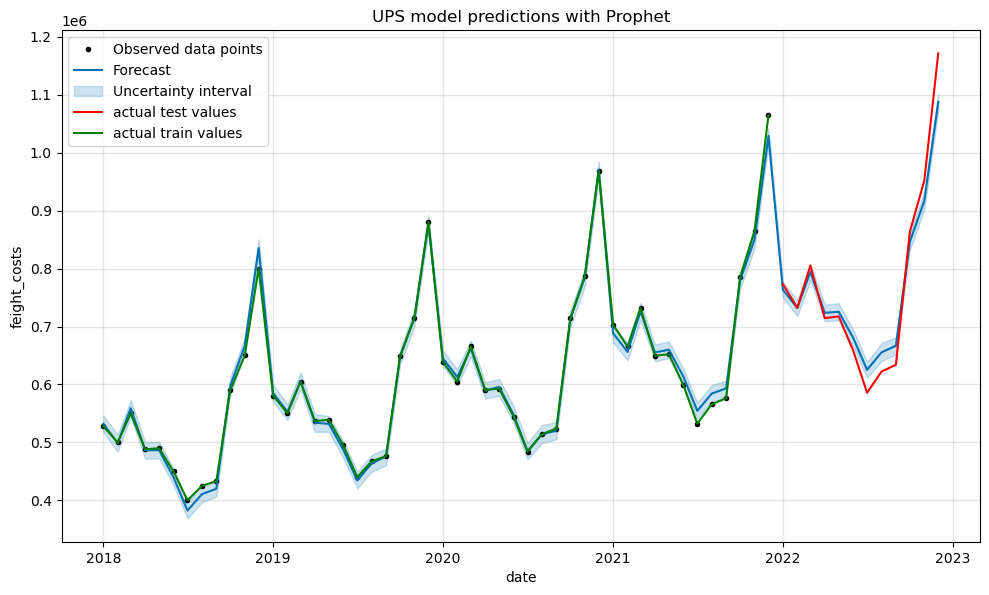

In [46]:
plot_predictions(ups_train, ups_test, ups_predictions, ups_model, 'UPS')

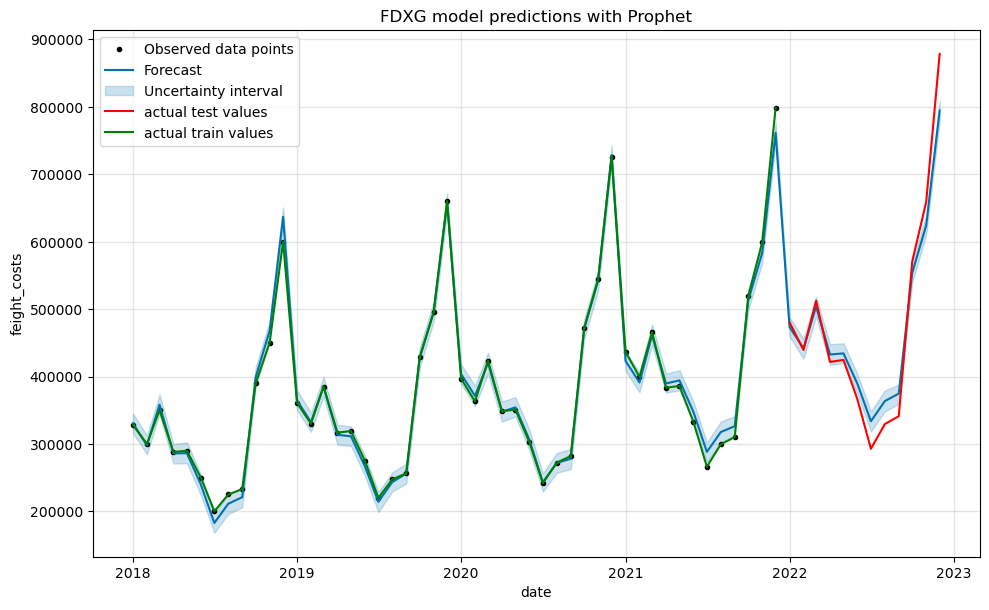

In [47]:
plot_predictions(fdxg_train, fdxg_test, fdxg_predictions, fdxg_model, 'FDXG')

In [48]:
def plot_components(model, predictions, carrier):
    model.plot_components(predictions)
    plt.title(f'{carrier} time series components')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


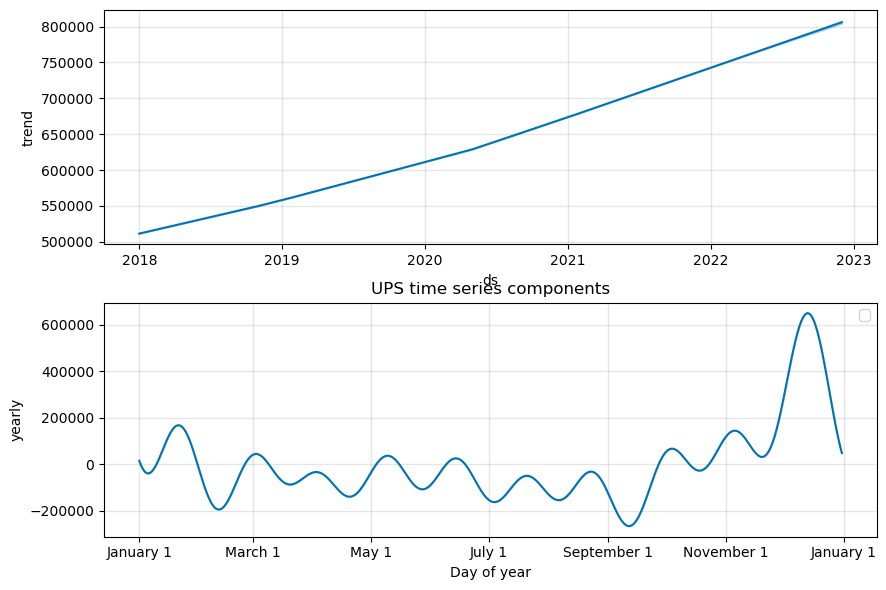

In [49]:
plot_components(ups_model, ups_predictions, 'UPS')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


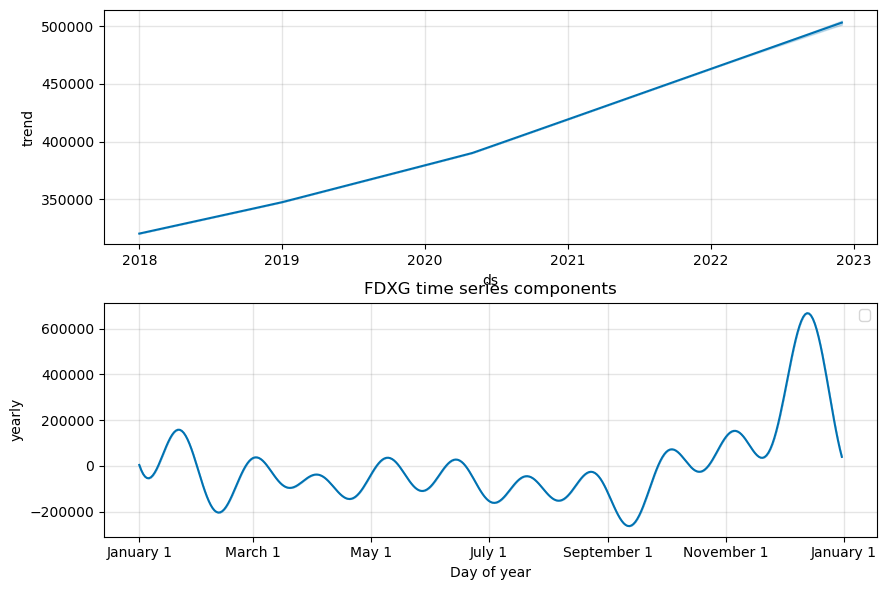

In [50]:
plot_components(fdxg_model, fdxg_predictions, 'FDXG')

In [51]:
import numpy as np
def calculate_error(predictions, actual):
    true_values = actual.y.to_numpy()
    predicted_values = predictions[-12:].yhat.to_numpy()

    rmse = np.sqrt(np.mean(predicted_values - true_values)**2)
    return np.round(rmse, 2)

print(f'UPS error mean squared error on test: {calculate_error(ups_predictions, ups_test)}')
print(f'FDXG error mean squared error on test: {calculate_error(fdxg_predictions, fdxg_test)}')

UPS error mean squared error on test: 1032.94
FDXG error mean squared error on test: 275.03


In [52]:
ups_test_predictions = pd.merge(
    left=ups_predictions[['ds', 'yhat']],
    right=ups_test[['ds', 'y']],
    how='inner',
    on='ds'
)

ups_test_predictions.y = ups_test_predictions.y.round(0)
ups_test_predictions.yhat = ups_test_predictions.yhat.round(0)
ups_test_predictions['difference'] = ups_test_predictions.yhat - ups_test_predictions.y
ups_test_predictions

,ds,yhat,y,difference
0,2022-01-01,763382.0,773045.0,-9663.0
1,2022-02-01,732077.0,732050.0,27.0
2,2022-03-01,794126.0,805255.0,-11129.0
3,2022-04-01,723520.0,714481.0,9039.0
4,2022-05-01,725477.0,717409.0,8068.0
5,2022-06-01,680596.0,658845.0,21751.0
6,2022-07-01,625259.0,585640.0,39619.0
7,2022-08-01,655396.0,622242.0,33154.0
8,2022-09-01,666790.0,633955.0,32835.0
9,2022-10-01,846443.0,863819.0,-17376.0


In [53]:
ups_predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,511461.772800,517783.322351,546766.283297,511461.772800,511461.772800,20495.376880,20495.376880,20495.376880,20495.376880,20495.376880,20495.376880,0.0,0.0,0.0,531957.149680
1,2018-02-01,515375.970154,483511.666769,513796.006556,515375.970154,515375.970154,-16673.693264,-16673.693264,-16673.693264,-16673.693264,-16673.693264,-16673.693264,0.0,0.0,0.0,498702.276890
2,2018-03-01,518911.374191,543484.634672,573206.906194,518911.374191,518911.374191,40079.151032,40079.151032,40079.151032,40079.151032,40079.151032,40079.151032,0.0,0.0,0.0,558990.525222
3,2018-04-01,522825.571517,471604.736983,500618.519926,522825.571517,522825.571517,-36390.263478,-36390.263478,-36390.263478,-36390.263478,-36390.263478,-36390.263478,0.0,0.0,0.0,486435.308039
4,2018-05-01,526613.504373,472550.689269,501029.363027,526613.504373,526613.504373,-40108.780639,-40108.780639,-40108.780639,-40108.780639,-40108.780639,-40108.780639,0.0,0.0,0.0,486504.723735


In [54]:
print(f'UPS error mean squared error on test: {np.sqrt(ups_test_predictions.difference ** 2).mean()}')

UPS error mean squared error on test: 25114.916666666668


In [55]:
fdxg_test_predictions = pd.merge(
    left=fdxg_predictions[['ds', 'yhat']],
    right=fdxg_test[['ds', 'y']],
    how='inner',
    on='ds'
)

fdxg_test_predictions.y = fdxg_test_predictions.y.round(0)
fdxg_test_predictions.yhat = fdxg_test_predictions.yhat.round(0)
fdxg_test_predictions['difference'] = fdxg_test_predictions.yhat - fdxg_test_predictions.y
fdxg_test_predictions

,ds,yhat,y,difference
0,2022-01-01,473347.0,480225.0,-6878.0
1,2022-02-01,441804.0,439230.0,2574.0
2,2022-03-01,503613.0,512435.0,-8822.0
3,2022-04-01,432644.0,421661.0,10983.0
4,2022-05-01,434289.0,424589.0,9700.0
5,2022-06-01,389150.0,366025.0,23125.0
6,2022-07-01,333587.0,292820.0,40767.0
7,2022-08-01,363497.0,329422.0,34075.0
8,2022-09-01,374652.0,341135.0,33517.0
9,2022-10-01,554045.0,570999.0,-16954.0


In [56]:
print(f'FDXG error mean squared error on test: {np.sqrt(fdxg_test_predictions.difference ** 2).mean()}')

FDXG error mean squared error on test: 25515.0
